<font size="8"> Titanic</font>  
<font size="5"> The solution with description</font>

# Import

First, let's import the necessary libs.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import pickle

import lightgbm as lgb

from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import DBSCAN

from tqdm import tqdm
import warnings
from IPython.display import display as disp

Let's import the libs made on my own.

There will be displayed the docs of these functions.

In [2]:
import sys
sys.path.append('/home/andrey/lib')

from common import correlation, index, walltime, load_datasets, any_precision_round
from machine_learning import proba_to_binary, lgbm_feature_importances
from preprocessing import columns_replace
from exploratory import quantile_order_numbers, groupby_fillna

# Functions

Here are some ad-hoc functions.

During the research stage, these functions were used more times in the code than in the current final version.

In [3]:
print(proba_to_binary.__doc__)


    Transforms the given array of predicted probabilities to the binary array
    according to the given threshold.
    
    pred_proba : list or numpy.array of float
        Array of predicted probabilities.
        
    threshold : float, default = 0.5
        Threshold the classes are transformed from probabilities according to.
        
    return : numpy.array of int
        Array of binary classes.
    


In [4]:
def ml_func(
    df_train,
    feature_names, 
    target_name, 
    algorithm,
    params, 
    seed, 
    threads, 
    cv, 
    repeats,
    proba_class_threshold=0.5,
    disp_plot=True, 
    disp_params=False, 
    silent=False):
    """
    Implementation of the training process.
    """
    
    # KFold index generator initialization
    rskf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=repeats, random_state=seed,)
    
    # Machine learning implementation (using CV)
    print('Computing... ', end='') if silent is not True else None
    score = []
    models = []
    for train_index, test_index in rskf.split(df_train[feature_names], df_train[target_name]):
        # Computing the class probabilities with a model.
        model, pred_proba = algorithm(df_train, train_index, test_index, feature_names, target_name, params,)
        pred = proba_to_binary(pred_proba, threshold=proba_class_threshold)
        
        # score for the current iteration
        score_curr = accuracy_score(df_train.loc[test_index, target_name], pred)
        score.append(score_curr)
        models.append(model)

    # mean score for all the iterations
    score_mean = np.round(np.mean(score), 5)
    print('done') if silent is not True else None

    # visualisation of the CV results
    if disp_plot:
        sns.kdeplot(score)
        plt.vlines(score_mean, ymin=0, ymax=2.0, colors='red')
        plt.xlabel(f'[mean: {score_mean}]')
        plt.xlim(0.7, 1.0)
        plt.show()

    # displaying
    if silent is not True:
        print(f'mean score: {score_mean}', end='')
        if disp_params:
            print(f'params: {params}')
        else:
            print('')
    
    #return
    return models
    #return (score_mean, params)

In [5]:
def lgbm_algorithm(df, train_index, test_index, feature_names, target_name, params,):
    """
    LightGBM model.
    """
    # dataset
    d_train = lgb.Dataset(
        df.loc[train_index, feature_names],
        df.loc[train_index, target_name],
        silent=True,
    )
    
    # fit
    model = lgb.train(params=params, train_set=d_train, verbose_eval=500,)
    
    # predict
    pred_proba = model.predict(df.loc[test_index, feature_names])
    
    return model, pred_proba

In [6]:
def ml_func_test(df_train, feature_names, target_name, params, seed, threads,):
    """
    Implementation of the training process using the entire dataset.
    """
    
    # Machine learning implementation
    print('Computing... ', end='')
    # dataset
    d_train = lgb.Dataset(df_train[feature_names],
                          df_train[target_name],
                          silent=True,
                         )
    # fit
    model = lgb.train(params=params, train_set=d_train, verbose_eval=500)
    print('done')

    return model

Also, once Random Forest was considered. Thus, there was such a function similar to "lgbm_algorithm", but now it is not necessary.

# Environment

Let's set the environment.

In [7]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 200)

sns.set()
warnings.filterwarnings('ignore')

# Parameters

The main ML algorithm used is LightGBM. It works fast and efficiently. Also, it is good in working with small datasets.

Here the dictionaries of the hyperparameters.

Several sets are used:
* for the baseline (was taken from a previous problem as is);
* for the final solution (finely tuned).

The final set is the third edition: parameters were tuned several times while researching.

"Basic" set is used for the baseline.

In [8]:
params_lgbm_basic = {
    "max_depth": 8,
    "num_leaves": 2 ** 8,
    "max_bin": 2 ** 6 - 1,
    "min_child_samples": 16,
    
    "num_iterations": 500,
    "learning_rate": 0.02,
}

This unnamed set is used for the final solution.

In [9]:
params_lgbm = {
    "max_depth": 7,
    "num_leaves": int(np.ceil(2 ** 7 * 0.6)),
    "feature_pre_filter": False,
    "min_data_in_leaf": 5,
    "min_sum_hessian_in_leaf": 2.0,
    "max_bin": 2 ** 6 - 1,
    "min_data_in_bin": 4,
    "lambda_l1": 0.25,
    "lambda_l2": 0.25,
    
    "num_iterations": 1000,
    "learning_rate": 0.010,
}

"Common" set is common for all the sets.

In [10]:
params_lgbm_common = {
    "objective": 'binary',
    "boost_from_average": False,
    "seed": 0,
    "verbosity": -1,
    "num_threads": 4,
    "feature_fraction": 0.75,
    "drop_rate": 0.5,
    "skip_drop": 0.2,
}

The full sets are the combinations of the subsets above.

In [11]:
params_lgbm_basic.update(params_lgbm_common)
params_lgbm.update(params_lgbm_common)

# The approach of dealing with the datasets

Some words about the approach chosen.

I considered both the train and the test datasets together as the one. In common, such an approach is unacceptable because we don't know anything about the data that comes new while using a model in production. So, using some of the "fit-transform" methods like scaling or implementing clusterization along both the datasets are a leakage.

Despite this, I found the approach acceptable in this case.
* We consider the unique situation with the finite number of entries: there are no other data at all. There are no more titanics or titanic disasters. We know about all the passengers. If it were a production, it is like we have a finite number of clients and try to predict something only for them.
* Clearly a "kagglish" reason: as it is a competition, I would like to maximize a score using all the available resources. I am sure, every participant does the same. The score can be comparable only if it is achieved in the same conditions.

# Skimming the data

Let's look at the data.

First, the information from the task.

## Data Dictionary

| Variable | Definition | Key |
|-------------|------------------|-----|
|survived | Survived | 0 = No, 1 = Yes
|pclass  | Ticket class  | 1 = 1st, 2 = 2nd, 3 = 3rd
|sex  | Sex  | 
|Age  | Age in years  | 
|sibsp  | siblings or spouses aboard the Titanic  | 
|parch  | parents or children aboard the Titanic  | 
|ticket  | Ticket number  | 
|fare  | Passenger fare  | 
|cabin  | Cabin number  | 
|embarked  | Port of Embarkation  | C = Cherbourg, Q = Queenstown, S = Southampton

## Variable Notes

pclass: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

## Data overview

Let's load the data and take a look at it.

In [12]:
print(load_datasets.__doc__)


    Loads both train and test datasets from a disk.
    
    filename_train : string
        The name of a file with train dataset without either path or
        extension (i.e.: "train").

    filename_test : string
        The test dataset likewise "filename_train".

    path : string
        The path to files.
    
    file_extension : string, default = "pkl"
        The extension of the files.
    
    sep : string, default = ","
        Delimiter of the columns (is used for csv-files only).

    return : sequence of two pandas.DataFrame objects
        The loaded data: train and test datasets.
    


In [13]:
df_train, df_test = load_datasets('train', 'test', './data/', file_extension='csv')

reading... done


In [14]:
df_full = pd.concat((df_train, df_test), ignore_index=True)

In [15]:
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


# Preprocessing

Here we discover gaps, duplicates, outliers and incorrect values.

Also, here are implemented data type reduction and some other utility procedures.

## Duplicates

Let's look for the duplicates excluding the *PassengerId* column.

In [17]:
df_full.iloc[:, 1:].duplicated().sum()

0

## Columns order

Let's separate feature and non-feature columns for more convenient handling.

In [18]:
print(columns_replace.__doc__)


    Changes the column order by swapping the given columns.
    
    df : pandas.DataFrame
        A dataframe that columns should be swapped of.
        
    col_a, col_b : string
        Names of the columns to swap.
    
    return : pandas.DataFrame
        A dataframe with the new order of columns.
    


In [19]:
disp(df_full.head(3))
df_full = columns_replace(df_full, 'Pclass', 'Name')
disp(df_full.head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


,PassengerId,Survived,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,"Braund, Mr. Owen Harris",3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,"Heikkinen, Miss. Laina",3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## PassengerId

In [20]:
df_full['PassengerId'].unique().shape

(1309,)

## Survived

In [21]:
df_full['Survived'].value_counts(dropna=False)

0.0    549
NaN    418
1.0    342
Name: Survived, dtype: int64

## Pclass

In [22]:
df_full['Pclass'].value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

## Name

In [23]:
df_full['Name'].unique().shape

(1307,)

In [24]:
df_full[df_full['Name'].duplicated(keep=False)]

,PassengerId,Survived,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
289,290,1.0,"Connolly, Miss. Kate",3,female,22.0,0,0,370373,7.7500,NaN,Q
696,697,0.0,"Kelly, Mr. James",3,male,44.0,0,0,363592,8.0500,NaN,S
891,892,NaN,"Kelly, Mr. James",3,male,34.5,0,0,330911,7.8292,NaN,Q
897,898,NaN,"Connolly, Miss. Kate",3,female,30.0,0,0,330972,7.6292,NaN,Q


It seems in these entries are mistakes in the *Name* field. As the remaining fields look right so we ignore them.

## Sex

In [25]:
df_full['Sex'].value_counts()

male      843
female    466
Name: Sex, dtype: int64

Let's convert it into binary.

In [26]:
if df_full['Sex'].dtype == object:
    df_full['Sex'] = df_full['Sex'].where(df_full['Sex'] == 'male', 0)
    df_full['Sex'] = df_full['Sex'].where(df_full['Sex'] == 0, 1)
    df_full['Sex'] = df_full['Sex'].astype('category')

In [27]:
df_full['Sex'].head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: category
Categories (2, int64): [0, 1]

## Age

Let's compare the statistics of the datasets.

In [28]:
df_full['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [29]:
df_train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [30]:
df_test['Age'].describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

It looks quite similar.

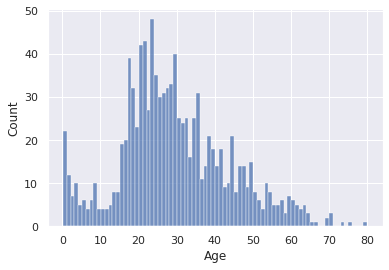

In [31]:
sns.histplot(df_full['Age'], bins=int(df_full['Age'].max()))
plt.show()

## SibSp

In [32]:
df_full['SibSp'].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

In [33]:
df_full['SibSp'] = df_full['SibSp'].astype('category')

## Parch

In [34]:
df_full['Parch'].value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

In [35]:
df_full['Parch'] = df_full['Parch'].astype('category')

## Ticket

Some cases of the same ticket number.

Mostly, such cases are families. Sometimes it could be passengers simply travelling together, as a group of Asians at the top of the table below.

In [36]:
df_full[df_full['Ticket'].isin(df_full['Ticket'].value_counts().index[:3])].sort_values(by='Ticket')

,PassengerId,Survived,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1.0,"Bing, Mr. Lee",3,1,32.0,0,0,1601,56.4958,NaN,S
169,170,0.0,"Ling, Mr. Lee",3,1,28.0,0,0,1601,56.4958,NaN,S
930,931,NaN,"Hee, Mr. Ling",3,1,NaN,0,0,1601,56.4958,NaN,S
838,839,1.0,"Chip, Mr. Chang",3,1,32.0,0,0,1601,56.4958,NaN,S
826,827,0.0,"Lam, Mr. Len",3,1,NaN,0,0,1601,56.4958,NaN,S
692,693,1.0,"Lam, Mr. Ali",3,1,NaN,0,0,1601,56.4958,NaN,S
509,510,1.0,"Lang, Mr. Fang",3,1,26.0,0,0,1601,56.4958,NaN,S
643,644,1.0,"Foo, Mr. Choong",3,1,NaN,0,0,1601,56.4958,NaN,S
59,60,0.0,"Goodwin, Master. William Frederick",3,1,11.0,5,2,CA 2144,46.9000,NaN,S
1031,1032,NaN,"Goodwin, Miss. Jessie Allis",3,0,10.0,5,2,CA 2144,46.9000,NaN,S


## Fare

In [37]:
df_full['Fare'].describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [38]:
df_full[df_full['Fare'] == 0].shape[0]

17

These are mistakes: a ticket can't be free. Let's change these with gaps for filling it later.

In [39]:
df_full['Fare'] = df_full['Fare'].where(df_full['Fare'] > 0, np.nan)

## Cabin

In [40]:
df_full['Pclass'].value_counts().sort_index()

1    323
2    277
3    709
Name: Pclass, dtype: int64

In [41]:
df_full.groupby(['Pclass'])['Cabin'].count().sort_index()

Pclass
1    256
2     23
3     16
Name: Cabin, dtype: int64

The numbers of cabins for the first-class passengers is known mostly. There is a historical reason why so.

## Embarked

In [42]:
df_full['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [43]:
df_full[df_full['Embarked'].isna()]

,PassengerId,Survived,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,"Icard, Miss. Amelie",1,0,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",1,0,62.0,0,0,113572,80.0,B28,NaN


It seems the port of embarkation shouldn't impact much on the probability of survival. So we can fill these gaps simply with the mode.

In [44]:
df_full['Embarked'] = df_full['Embarked'].fillna(df_full['Embarked'].value_counts().idxmax())

In [45]:
df_full['Embarked'] = df_full['Embarked'].astype('category')

## Results

In [46]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    float64 
 2   Name         1309 non-null   object  
 3   Pclass       1309 non-null   int64   
 4   Sex          1309 non-null   category
 5   Age          1046 non-null   float64 
 6   SibSp        1309 non-null   category
 7   Parch        1309 non-null   category
 8   Ticket       1309 non-null   object  
 9   Fare         1291 non-null   float64 
 10  Cabin        295 non-null    object  
 11  Embarked     1309 non-null   category
dtypes: category(4), float64(3), int64(2), object(3)
memory usage: 88.0+ KB


In [47]:
df_full.head()

,PassengerId,Survived,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,"Braund, Mr. Owen Harris",3,1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,"Heikkinen, Miss. Laina",3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,"Allen, Mr. William Henry",3,1,35.0,0,0,373450,8.0500,NaN,S


# Baseline

Here we launch the training the first time using the given data as is. The parameters of the model also haven't been tuned yet.

Only we need to exclude text features (dtype "string").

## Feature names

In [48]:
target_name = 'Survived'

feature_names = [
    'Pclass', 
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    #'Ticket',
    'Fare',
    #'Cabin',
    'Embarked',
]

## LightGBM

In [49]:
print(walltime.__doc__)


    Measures the wall time without any extra consumption of the system resources.

    Functions:
    ----------    
    __init__ :
        The initial function.
    
    end :
        Takes the current time and calculates the wall time as the time interval
        since initializing.

    Attributes:
    ----------
    wall_total_seconds : int
        Contains the total amount of seconds of the fixed time interval.
    


Computing... done


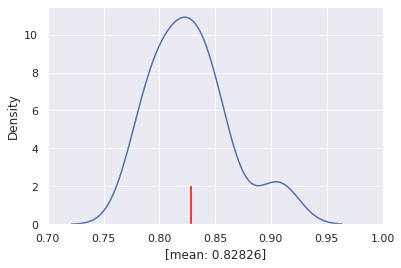

mean score: 0.82826

wall:  0m 06s


In [50]:
wall = walltime()

models_lgbm_base = ml_func(
    df_full[df_full['Survived'].isna() != True],
    feature_names,
    target_name,
    lgbm_algorithm,
    params_lgbm_basic,
    seed=1,
    threads=4,
    cv=10,
    repeats=3,
)

wall.end()

This is a distribution (KDE-function) of the scores got. The total amount of scores is equal to (cv * repeats).

Due to such representation, we can comprehend the result deeper than if only looking at a table.

# Exploratory and feature extraction

## Cabin

### Filling NaNs with modes

In [51]:
print(groupby_fillna.__doc__)


    Fills NaNs in the target column with the aggregated values calculated
    individually for each group of entries.
    
    Entries are grouped by the columns from "groupers" (the core method is
    "groupby()" from pandas). Aggregated values for each of the groups are
    calculated from target values that are not NaNs.
    
    Each aggregated value is used for filling NaNs only within its group. Such
    an approach helps to achieve higher precision.
    
    The function works well with category and string dtypes too. In these
    cases, the aggregation function is "mode" (the most frequent value within
    the group) regardless of the aggfunc value. The function "mode" is realized
    as an internal function.
    
    df : pandas.DataFrame
        A dataframe containing columns from "groupers" and a target column.
    
    groupers : sequence of strings
        Names of the columns of a given dataframe that are used for grouping
        entries.
    
    target : string
      

In [52]:
disp(df_full['Cabin'].count())
df_full = groupby_fillna(df_full, ['Ticket'], 'Cabin',)
disp(df_full['Cabin'].count())

295

311

### Decks

Let's extract the labels of the decks.

The label of a deck is the first letter of the cabin number.

In [53]:
df_full['Deck'] = df_full['Cabin'].str.get(0)

In [54]:
df_full['Deck'].value_counts()

C    104
B     68
D     46
E     42
F     23
A     22
G      5
T      1
Name: Deck, dtype: int64

In [55]:
df_full[df_full['Deck'] == 'T']

,PassengerId,Survived,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
339,340,0.0,"Blackwell, Mr. Stephen Weart",1,1,45.0,0,0,113784,35.5,T,S,T


Let's change the deck label "T" (unique) to "C" (the most frequent among the first-class cabins).

In [56]:
Deck_T_index = df_full[df_full['Deck'] == 'T'].index
df_full.loc[Deck_T_index, ['Cabin', 'Deck']] = 'C'

df_full.loc[Deck_T_index, ['Cabin', 'Deck']]

,Cabin,Deck
339,C,C


The gaps are filled with the label "U" which means "unknown".

In [57]:
df_full['Deck'] = df_full['Deck'].fillna('U').astype('category')
df_full['Deck']

0       U
1       C
2       U
3       C
4       U
       ..
1304    U
1305    C
1306    U
1307    U
1308    F
Name: Deck, Length: 1309, dtype: category
Categories (8, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'U']

In [58]:
df_full.head()

,PassengerId,Survived,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0.0,"Braund, Mr. Owen Harris",3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,U
1,2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1.0,"Heikkinen, Miss. Laina",3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,U
3,4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,35.0,1,0,113803,53.1000,C123,S,C
4,5,0.0,"Allen, Mr. William Henry",3,1,35.0,0,0,373450,8.0500,NaN,S,U


### Cabin bin

Let's create the binary feature if the number of a cabin exists or not.

In [59]:
df_full['Cabin_bin'] = 0
df_full['Cabin_bin'] = df_full['Cabin_bin'].where(df_full['Cabin'].isna(), 1).astype('category')

### Even or odd

This feature indicates if the last digit is even or odd. It is necessary because of the suggestion that the rescue process could be provided differently at the left and the right sides of the ship.

Here the ad-hoc function extracting this feature. The "apply()" method works slowly, however, due to the small size of the dataset we can afford it.

In [60]:
def cabin_even_or_odd(x):
    """
    Recognizes is the last symbol an even or an odd digit.
    Returns the respective string label.
    """
    try:
        string = str(x)
        digit = int(string[-1])

        if np.mod(digit, 2) == 0:
            return 0
        elif np.mod(digit, 2) == 1:
            return 1
        else:
            return -1
    except:
        return -1

In [61]:
df_full['Cabin_even_odd'] = df_full['Cabin'].apply(cabin_even_or_odd).astype('category')

### Cabin number

Cabin numbers tell us about the lengthwise position of cabins. It also can impact the probability of survival.

Firstly, let's fill NaNs with zeros. And then another function comes up.

In [62]:
df_full['Cabin'] = df_full['Cabin'].fillna(0)

In [63]:
def cabin_number_func(x):
    """
    Extracts the cabin number as a numeric. 
    """
    string = str(x)
    match = re.search(r'\d+\b', string)
    if match:
        return int(match[0])
    else:
        return 0

In [64]:
df_full['Cabin_number'] = df_full['Cabin'].apply(cabin_number_func)
df_full['Cabin_number'].head()

0      0
1     85
2      0
3    123
4      0
Name: Cabin_number, dtype: int64

### Cabin as a category

The fact is that somehow the whole number of a cabin (the deck label and the numeric number together) using jointly with already extracted separate features also provides a bit enhancing of the score. Probably, it is so because passengers from the same cabin could have an alike fate.

In [65]:
df_full['Cabin'] = df_full['Cabin'].astype('category')

## Name

### Title

The *Name* column has a particular structure that we can extract the persons' titles from it.

In [66]:
df_full['Name'].head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [67]:
def name_title_extraction(x):
    match1 = re.search(r', \w+.* ', x)
    if match1:
        match2 = re.search(r'\w+', match1[0])
        if match2:
            return match2[0]
        else:
            return 'none'
    else:
        return 'none'

In [68]:
df_full['Title'] = df_full['Name'].apply(name_title_extraction)

In [69]:
df_full['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Major         2
Mlle          2
the           1
Sir           1
Dona          1
Don           1
Jonkheer      1
Lady          1
Capt          1
Mme           1
Name: Title, dtype: int64

What is the "the"?

In [70]:
df_full[df_full['Name'].str.contains(', the')]

,PassengerId,Survived,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Cabin_bin,Cabin_even_odd,Cabin_number,Title
759,760,1.0,"Rothes, the Countess. of (Lucy Noel Martha Dye...",1,0,33.0,0,0,110152,86.5,B77,S,B,1,1,77,the


It is good to reduce the variety of the titles. Here the dictionary the reduction is provided according to.

In [71]:
title_transform_dict = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Rev': 'Aristocratic',
    'Dr': 'Aristocratic',
    'Col': 'Officer',
    'Mlle': 'Miss',
    'Major': 'Officer',
    'Ms': 'Mrs',
    'Capt': 'Officer',
    'the': 'Royal',
    'Don': 'Royal',
    'Sir': 'Royal',
    'Dona': 'Royal',
    'Lady': 'Royal',
    'Mme': 'Mrs',
    'Jonkheer': 'Royal',
}

In [72]:
df_full['Title'] = df_full['Title'].apply(lambda x: title_transform_dict[x])
df_full['Title'] = df_full['Title'].astype('category')

In [73]:
df_full['Title'].value_counts()

Mr              757
Miss            262
Mrs             200
Master           61
Aristocratic     16
Officer           7
Royal             6
Name: Title, dtype: int64

### Dropping Name column

We don't need the *Name* column more.

In [74]:
df_full = df_full.drop(columns='Name')

## Ticket

### Family

Here we count the amount of passengers whose ticket with an identical number. Mostly, these are families. So, we can consider it as the family size.

In [75]:
Ticket_counts = df_full['Ticket'].value_counts().reset_index().rename(columns={'Ticket': 'Family'})
Ticket_counts.head()

,index,Family
0,CA. 2343,11
1,1601,8
2,CA 2144,8
3,S.O.C. 14879,7
4,3101295,7


In [76]:
df_full = df_full.merge(Ticket_counts, how='left', left_on='Ticket', right_on='index').drop(columns='index')
df_full.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Cabin_bin,Cabin_even_odd,Cabin_number,Title,Family
0,1,0.0,3,1,22.0,1,0,A/5 21171,7.2500,0,S,U,0,-1,0,Mr,1
1,2,1.0,1,0,38.0,1,0,PC 17599,71.2833,C85,C,C,1,1,85,Mrs,2
2,3,1.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,U,0,-1,0,Miss,1
3,4,1.0,1,0,35.0,1,0,113803,53.1000,C123,S,C,1,1,123,Mrs,2
4,5,0.0,3,1,35.0,0,0,373450,8.0500,0,S,U,0,-1,0,Mr,1


### Quantiles

Here we divide the family sizes by quantiles (groupping).

In [77]:
print(quantile_order_numbers.__doc__)


    Forms the series of order numbers of quantiles based on the series given.
    
    First, the array of quantiles is computed according to the quantiles'
    amount (q_amount). The quantities of entries within intervals between
    quantiles are equal.
    
    Then, if in the array of quantiles are duplicates, the dropping is provided.
    Thus, some of the intervals can be united, and the final amount of the
    unique order numbers can be less than given at the beginning (q_amount).
        E.g.:
        q_amount: 10
        array of quantiles: [1, 3, 6, 7, 7, 8, 9, 9, 9, 11,] (n = 10 = q_amount)
        array of order numbers: [1, 3, 6, 7, 8, 9, 11,] (n = 7 < q_amount)
    
    So, the result can be considered as a category of an initial value.
    However, the result is returned as an integer not a category because more
    likely it will be needed as a quantitive measure of the respective initial
    value.
    
    Finally, the forming of the resulting series is implemented.

Eventually, this feature comes up as unnecessary because of its about-zero impact on the score and its importance level (*feature importance*).

In [78]:
q_amount_Family = 8

qnt_Family = quantile_order_numbers()
qnt_Family.fit(df_full['Family'], q_amount_Family)
# unnecessary feature!
# df_full['Family_qnt'] = qnt_Family.transform(df_full['Family'])
# df_full['Family_qnt'] = df_full['Family_qnt'].astype('category')

qnt_Family.get_quantiles()

0     1.0
1     2.0
2     3.0
3     4.0
4    11.0
dtype: float64

### Family bin

The feature indicates if a passenger has a family or not.

In [79]:
df_full['Family_bin'] = 0
df_full['Family_bin'] = df_full['Family_bin'].where(df_full['Family'] == 1, 1).astype('category')

### Ticket as a category

Let's consider the ticket number as a category. This can work for the same reasons as the full cabin number (we looked at it above).

In [80]:
df_full['Ticket'] = df_full['Ticket'].astype('category')

## Fare

### Fare specific

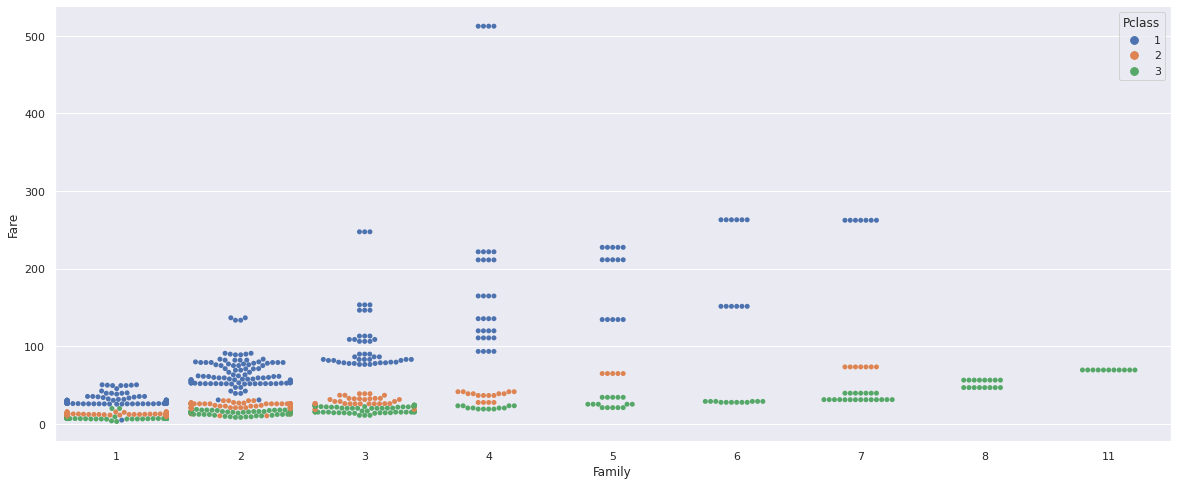

In [81]:
plt.figure(figsize=(20, 8))
sns.swarmplot(data=df_full, x='Family', y='Fare', hue='Pclass')
plt.show()

It looks like a dependence between the fare and the family size. Probably, the *Fare* can be the total fare size paid for all the family.

Let's calculate the specific fare for each passenger.

In [82]:
df_full['Fare_specific'] = df_full['Fare'] / df_full['Family']

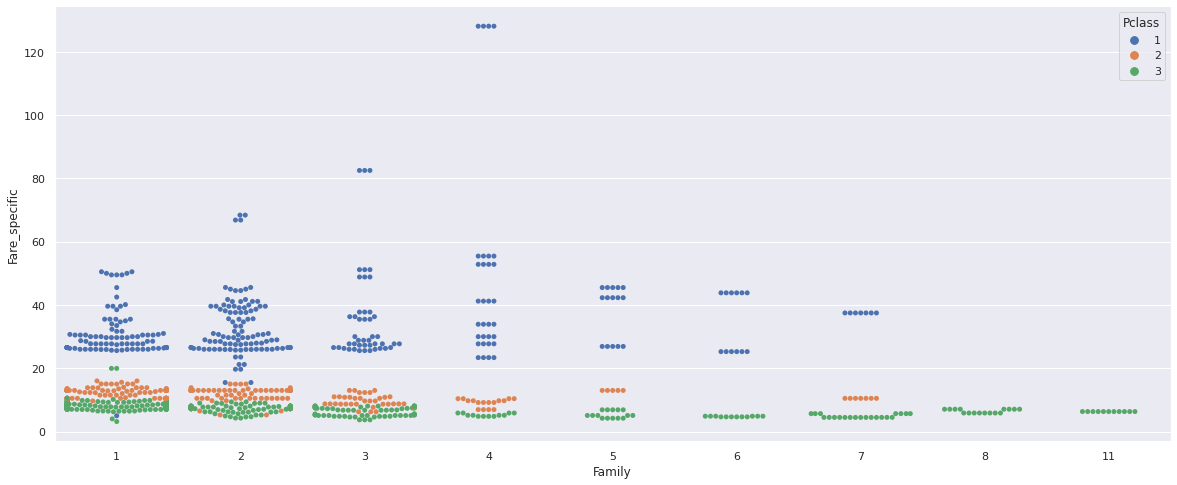

In [83]:
plt.figure(figsize=(20, 8))
sns.swarmplot(data=df_full, x='Family', y='Fare_specific', hue='Pclass')
plt.show()

The suggestion turns out right. Looks nice.

### Filling NaNs

In [84]:
df_full.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Cabin_bin,Cabin_even_odd,Cabin_number,Title,Family,Family_bin,Fare_specific
0,1,0.0,3,1,22.0,1,0,A/5 21171,7.2500,0,S,U,0,-1,0,Mr,1,0,7.25000
1,2,1.0,1,0,38.0,1,0,PC 17599,71.2833,C85,C,C,1,1,85,Mrs,2,1,35.64165
2,3,1.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,U,0,-1,0,Miss,1,0,7.92500
3,4,1.0,1,0,35.0,1,0,113803,53.1000,C123,S,C,1,1,123,Mrs,2,1,26.55000
4,5,0.0,3,1,35.0,0,0,373450,8.0500,0,S,U,0,-1,0,Mr,1,0,8.05000


In [85]:
disp(df_full[df_full['Fare'].isna()].count().max())
disp(df_full[df_full['Fare_specific'].isna()].count().max())

18

18

The amount of non-NaNs in the columns *Fare* and *Fare_specific* is equal, as expected.

Let's fill NaNs with higher precision.

#### Iteration 0

In [86]:
groupers = [
    'Pclass',
    'Sex',
    'Title',
    'Age',
]

df_full = groupby_fillna(df_full, groupers, 'Fare', 'median',)
df_full = groupby_fillna(df_full, groupers, 'Fare_specific', 'median',)

In [87]:
disp(df_full[df_full['Fare'].isna()].count().max())
disp(df_full[df_full['Fare_specific'].isna()].count().max())

12

12

Some of NaNs remain. That is because of the NaNs in the *Age* column.

Let's fill the remain NaNs grouping entries without the *Age* grouper.

#### Iteration 1

In [88]:
groupers = [
    'Pclass',
    'Sex',
    'Title',
]

df_full = groupby_fillna(df_full, groupers, 'Fare', 'median',)
df_full = groupby_fillna(df_full, groupers, 'Fare_specific', 'median',)

In [89]:
disp(df_full[df_full['Fare'].isna()].count().max())
disp(df_full[df_full['Fare_specific'].isna()].count().max())

0

0

NaNs are filled.

### Rounding values

In [90]:
df_full['Fare_specific'].head()

0     7.25000
1    35.64165
2     7.92500
3    26.55000
4     8.05000
Name: Fare_specific, dtype: float64

The *Fare* and *Fare_specific* columns look untidy: a huge variety of close values; the unrounded remainder of the division. The values should be rounded off at least two decimals because the smallest multiple of values in USD and all the European currencies is the value of 0.01.

But, in order to reduce the amount of the unique values we round them so they become multiples of 0.05.

Next, the value of the multiple of 0.5 turns out the best.

In [91]:
print(any_precision_round.__doc__)


    Rounds a value (or array-like) out to the nearest multiple of the precision.
    If a precision value is within [10^N; N >> integer], the function works as a
    common round function.
    
        Examples:
        precision = 0.02; 2.845 >> 2.840;  2.852 >> 2.860
        precision = 15;   6.426 >> 0.0;   13.426 >> 15.0
    
    The function solves the problem of the incorrect rounding of values that are
    almost in the middle of the interval between two neighbour multiples of the
    precision.
        
        Examples: 1.499999999; 2.500000001 etc.
        
    The problem arises while the binary representation of decimals.
    The error doesn't arise up to 1e-10 precision of rounding.
    
    a : scalar or array-like
        A value (array of values) to round.
    
    precision : float, default = 1.0
        A multiple of the precision, which is the closest to "a", is the
        rounded value of "a".
    
    return : float or numpy.array
        The rounded value (array

In [92]:
precision = 0.5  #0.05

df_full['Fare'] = any_precision_round(df_full['Fare'], precision=precision)
df_full['Fare_specific'] = any_precision_round(df_full['Fare_specific'], precision=precision)

In [93]:
df_full.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Cabin_bin,Cabin_even_odd,Cabin_number,Title,Family,Family_bin,Fare_specific
0,1,0.0,3,1,22.0,1,0,A/5 21171,7.5,0,S,U,0,-1,0,Mr,1,0,7.5
1,2,1.0,1,0,38.0,1,0,PC 17599,71.5,C85,C,C,1,1,85,Mrs,2,1,35.5
2,3,1.0,3,0,26.0,0,0,STON/O2. 3101282,8.0,0,S,U,0,-1,0,Miss,1,0,8.0


### Quantiles

Another attempt of using the quantiles. These turned out unnecessary.

In [94]:
q_amount_Fare = 5

qnt_Fare = quantile_order_numbers()
qnt_Fare.fit(df_full['Fare'], q_amount_Fare)
# unnecessary feature!
# df_full['Fare_qnt'] = qnt_Fare.transform(df_full['Fare'])
# df_full['Fare_qnt'] = df_full['Fare_qnt'].astype('category')

qnt_Fare.get_quantiles()

0      8.0
1     11.1
2     22.5
3     42.5
4    512.5
dtype: float64

The quantiles of the "Fare_specific" are useful.

In [95]:
q_amount_Fare_specific = 5

qnt_Fare_specific = quantile_order_numbers()
qnt_Fare_specific.fit(df_full['Fare_specific'], q_amount_Fare_specific)
df_full['Fare_specific_qnt'] = qnt_Fare_specific.transform(df_full['Fare_specific'])
df_full['Fare_specific_qnt'] = df_full['Fare_specific_qnt'].astype('category')

qnt_Fare_specific.get_quantiles()

0      7.5
1      8.0
2     10.5
3     26.5
4    128.0
dtype: float64

## Age

### Age estimated

If we have the information that the tail ".5" is meaningful, we should highlight such entries.

In [96]:
pattern = '.5'
df_full['Age_estimated'] = 0
df_full.loc[df_full['Age'][df_full['Age'].astype('str').str.endswith(pattern)].index, 'Age_estimated'] = 1
df_full['Age_estimated'] = df_full['Age_estimated'].astype('category')

In [97]:
df_full['Age_estimated'].value_counts()

0    1276
1      33
Name: Age_estimated, dtype: int64

### Filling NaNs

In the "Age" column are a lot of NaNs.

In [98]:
disp(df_full[df_full['Age'].isna()].count().max())
disp(df_full[df_full['Age'].isna()].count().max() / df_full.shape[0])

263

0.20091673032849502

In [99]:
df_full.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Cabin_bin,Cabin_even_odd,Cabin_number,Title,Family,Family_bin,Fare_specific,Fare_specific_qnt,Age_estimated
0,1,0.0,3,1,22.0,1,0,A/5 21171,7.5,0,S,U,0,-1,0,Mr,1,0,7.5,1,0
1,2,1.0,1,0,38.0,1,0,PC 17599,71.5,C85,C,C,1,1,85,Mrs,2,1,35.5,4,0
2,3,1.0,3,0,26.0,0,0,STON/O2. 3101282,8.0,0,S,U,0,-1,0,Miss,1,0,8.0,2,0


Let's use the higher precision filling function again.

In the first attempt, there was a usage of the maximum amount of the necessary features. But next, it turned out that one of them makes the score worse and was excluded. The reason is the "exceed" precision: such groups seem too small and the learning was obstructed.

Grouping by only three features is enough.

In [100]:
groupers = [
    'Pclass', 
    'Sex', 
    'Title',
    # Fare_specific_qnt ---> this feature makes the score worse while submitting!!!
]

df_full = groupby_fillna(df_full, groupers, 'Age', 'median',)

In [101]:
df_full[df_full['Age'].isna()].count()

PassengerId          0
Survived             0
Pclass               0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin                0
Embarked             0
Deck                 0
Cabin_bin            0
Cabin_even_odd       0
Cabin_number         0
Title                0
Family               0
Family_bin           0
Fare_specific        0
Fare_specific_qnt    0
Age_estimated        0
dtype: int64

### Rounding values

The age we round off simply to an integer. The passengers whose age is from 0 to 1 were rounded to 1.

In [102]:
df_full['Age'] = df_full['Age'].round()
df_full['Age'] = df_full['Age'].where(df_full['Age'] > 1, 1)

### Quantiles

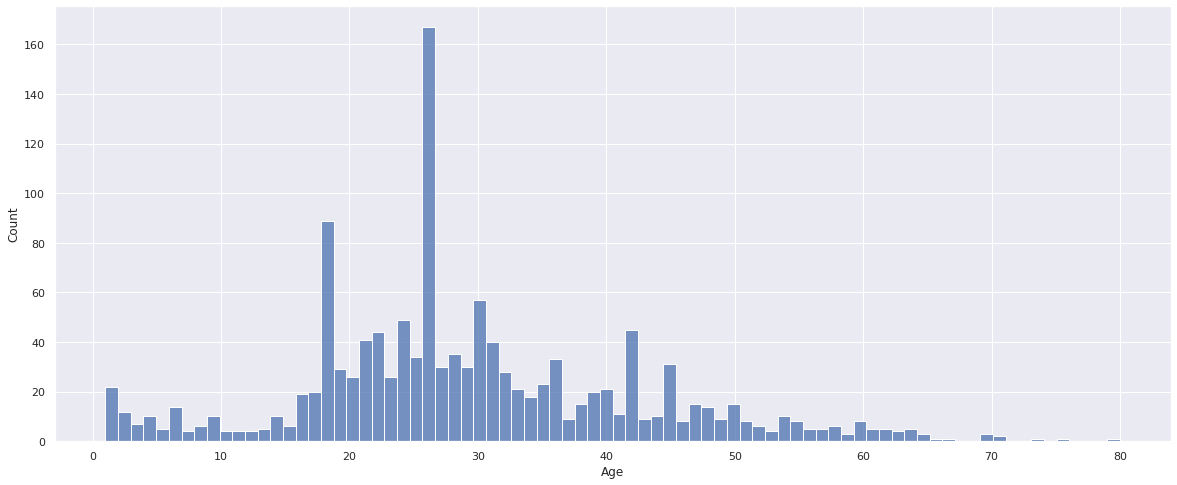

In [103]:
plt.figure(figsize=(20, 8))
sns.histplot(df_full['Age'], bins=int(df_full['Age'].max()))
plt.show()

Let's divide the "Age" column into groups. But here using the real quantiles seems unnecessary: here we use the bounds defined manually according to the histplot.

In [104]:
quantiles_Age = [3, 13, 20, 38, 50,]

qnt_Age = quantile_order_numbers()
qnt_Age.set_quantiles(quantiles_Age)
df_full['Age_qnt'] = qnt_Age.transform(df_full['Age'])
df_full['Age_qnt'] = df_full['Age_qnt'].astype('category')

qnt_Age.get_quantiles()

0     3
1    13
2    20
3    38
4    50
dtype: int64

In [105]:
df_full['Age_qnt'].value_counts().sort_index()

0     34
1     68
2    178
3    711
4    318
Name: Age_qnt, dtype: int64

# Machine learning

Let's look at the features again, check up the dtypes finally etc.

In [106]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   PassengerId        1309 non-null   int64   
 1   Survived           891 non-null    float64 
 2   Pclass             1309 non-null   int64   
 3   Sex                1309 non-null   category
 4   Age                1309 non-null   float64 
 5   SibSp              1309 non-null   category
 6   Parch              1309 non-null   category
 7   Ticket             1309 non-null   category
 8   Fare               1309 non-null   float64 
 9   Cabin              1309 non-null   category
 10  Embarked           1309 non-null   category
 11  Deck               1309 non-null   category
 12  Cabin_bin          1309 non-null   category
 13  Cabin_even_odd     1309 non-null   category
 14  Cabin_number       1309 non-null   int64   
 15  Title              1309 non-null   category
 16  Family

## Correlation

In [107]:
print(correlation.__doc__)


    The visualized correlation matrix.
    


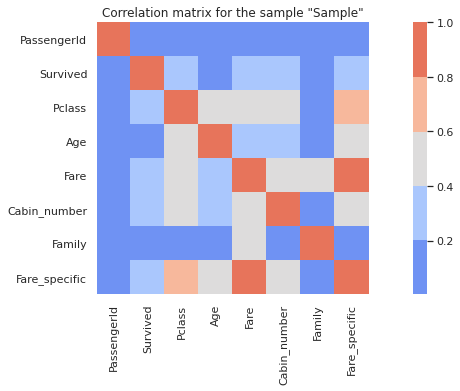


high-correlated features (2 pairs):


,feat_1,feat_2,corr
0,Fare_specific,Fare,0.818931
1,Fare_specific,Pclass,0.791996


In [108]:
corr = correlation()
corr.correlation_heatmap(df_full)
corr.correlation_heatmap_show()
corr.correlation_list(threshold=0.7)
corr.correlation_list_show()

The acceptable value of the Pearson coefficient is up to ~ 0.82 ... 0.85 in this case.

Anyway, the high-correlated features (like *Fare* and *Fare_specific*) should be tried applying separately to find the best solution. It was done here, and the best solution is to use them all.

## Feature names

Here we form the list of features.

In [109]:
print(index.__doc__)


    Returns the index (number) of the column by its name.

    df : pandas.DataFrame
        The dataframe whose column is considered.
    
    col_name : string
        The name of the column whose index is being looked for.
    
    return : int or numpy.nan
        The number of the column if it exists, numpy.nan otherwise.
    


In [110]:
target_name = 'Survived'

names_exclude = [
    'Ticket',
]

feature_names = df_full.select_dtypes(exclude=['object']).columns[index(df_full, 'Pclass'):]
feature_names = feature_names[feature_names.isin(names_exclude) != True]
feature_names

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked',
       'Deck', 'Cabin_bin', 'Cabin_even_odd', 'Cabin_number', 'Title',
       'Family', 'Family_bin', 'Fare_specific', 'Fare_specific_qnt',
       'Age_estimated', 'Age_qnt'],
      dtype='object')

## ML feature extraction

The last feature which was extracted is the feature made with ML: decomposition and clusterization algorithms were applied.

The general difference comparing with any supervised algorithms is possibility of using the entire dataset (both parts train and test) for training and scoring because the target vector is not required. So, we can, not only extract a piece of new information from the already existing features due to using fundamentally another algorithm (comparing with "woody" algorithms like Forests or Boostings) but also get more information from the test dataset this way (the reasons why this is acceptable here were described in the beginning).

Several algorithms were tried while researching. The best results were achieved with *SpectralEmbedding* for decomposition and *DBSCAN* for clustering. The metric used for scoring the results of the clusterization is *silhouette_score* because it doesn't require the target vector (some of the metrics require).

In [111]:
df_full.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Cabin_bin,Cabin_even_odd,Cabin_number,Title,Family,Family_bin,Fare_specific,Fare_specific_qnt,Age_estimated,Age_qnt
0,1,0.0,3,1,22.0,1,0,A/5 21171,7.5,0,S,U,0,-1,0,Mr,1,0,7.5,1,0,3
1,2,1.0,1,0,38.0,1,0,PC 17599,71.5,C85,C,C,1,1,85,Mrs,2,1,35.5,4,0,4
2,3,1.0,3,0,26.0,0,0,STON/O2. 3101282,8.0,0,S,U,0,-1,0,Miss,1,0,8.0,2,0,3


First, we need to transform the categorical feature dtypes from string to numeric using *OrdinalEncoder*.

In [112]:
feature_names_cat = [
    'Ticket',
    'Cabin',
    'Embarked',
    'Deck',
    'Title',
]

In [113]:
encoder = OrdinalEncoder()

df_full_oe = df_full.copy()
df_full_oe[feature_names_cat] = encoder.fit_transform(df_full_oe[feature_names_cat].astype('str'))
df_full_oe = df_full_oe.drop(columns='Survived')

### Searching

Here is the implementation of searching for the best solution for clusterization.

This grid covers all the common-sense values of the hyperparameters. Such a grid requires too much computational time.

In [114]:
embedding_params = {
    'n_components': np.arange(2, 50, 1, dtype='int'),
    'n_neighbors': np.arange(2, 50, 1, dtype='int'),
}

cluster_params = {
    'eps': np.arange(1e-3, 5e-2, 1e-3),
    'min_samples': np.arange(2, 50, 1, dtype='int'),
}

So, for the first, we try to use the reduced grid. It is highly likely the best set is within these intervals.

In [115]:
embedding_params = {
    'n_components': np.arange(5, 50, 5, dtype='int'),
    'n_neighbors': np.arange(2, 20, 2, dtype='int'),
}

cluster_params = {
    'eps': np.arange(1e-3, 2e-2, 1e-3),
    'min_samples': np.arange(2, 10, 1, dtype='int'),
}

Simple brute force iteration.

In [116]:
results = []

for n_components in tqdm(embedding_params['n_components']):
    try:
        for n_neighbors in embedding_params['n_neighbors']:
            try:
                emb_0 = SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors, random_state=1, n_jobs=4,)
                arr_full_emb_0 = emb_0.fit_transform(df_full_oe)

                for eps in cluster_params['eps']:
                    try:
                        for min_samples in cluster_params['min_samples']:
                            try:
                                clstr = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=4,)
                                arr_full_clstr = clstr.fit_predict(arr_full_emb_0)
                                score = silhouette_score(arr_full_emb_0, arr_full_clstr)
                                results.append([n_components, n_neighbors, eps, min_samples, score])
                            except:
                                break
                    except:
                        break
            except:
                break
    except:
        break

100%|██████████| 9/9 [26:31<00:00, 176.83s/it]


In [117]:
results = np.array(results)
results[np.argmax(results[:, 4])]

array([1.00000000e+01, 2.00000000e+00, 1.00000000e-03, 2.00000000e+00,
       9.99999991e-01])

The solution with the highest possible score was found: the score is 1.0!

(See the last value in the array).

Let's look at the solution closer.

### Decomposition

In [118]:
wall = walltime()

emb_0 = SpectralEmbedding(
    n_components = 10,
    n_neighbors = 2,
    random_state=1,
    n_jobs=4,
)

arr_full_emb_0 = emb_0.fit_transform(df_full_oe)

wall.end()


wall:  0m 00s


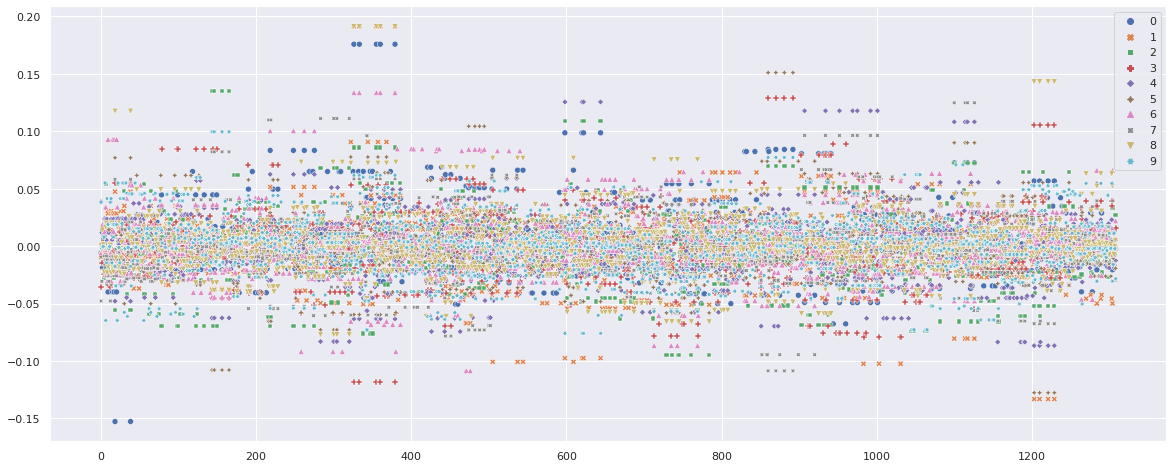

In [119]:
plt.figure(figsize=(20, 8))
sns.scatterplot(data=arr_full_emb_0)
plt.show()

### Clusterization

In [120]:
clstr = DBSCAN(
    eps=0.001,
    min_samples=2,
    n_jobs=4,
)

arr_full_clstr = clstr.fit_predict(arr_full_emb_0)
df_full['cluster_0'] = arr_full_clstr

print('Score: {:.3f}\n'.format(silhouette_score(arr_full_emb_0, arr_full_clstr)))
disp(df_full['cluster_0'].value_counts().head(10))
disp(df_full['cluster_0'].value_counts()[df_full['cluster_0'].value_counts() > 1].count())
disp(df_full['cluster_0'].value_counts().count())

Score: 1.000



38     11
332    10
105     8
328     8
45      8
274     8
78      7
22      7
287     7
203     7
Name: cluster_0, dtype: int64

373

373

## Datasets

Let's split the full dataset into the train and the test.

In [121]:
df_train = df_full[df_full['Survived'].isna() != True]
df_test  = df_full[df_full['Survived'].isna()]

In [122]:
disp(df_train.shape)
disp(df_test.shape)

(891, 23)

(418, 23)

## Model

Here is the forming of the final feature set.

In [123]:
feature_names_lgbm = [
    *feature_names,
    'cluster_0',
]

Here the machine learning is implemented.

Using several seeds (sometimes up to 4) is necessary to enhance the reliability of the results of the validation because the number of daily submissions is restricted.

Computing... done


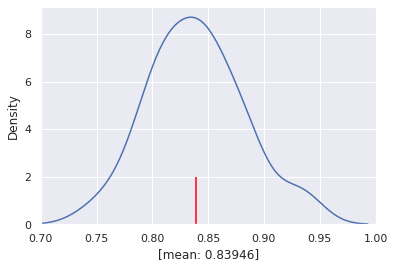

mean score: 0.83946

wall:  0m 21s


In [124]:
wall = walltime()

for seed in range(1, 2):
    models_lgbm = ml_func(
        df_train,
        feature_names_lgbm,
        target_name,
        lgbm_algorithm,
        params_lgbm,
        seed=seed,
        threads=4,
        cv=15,
        repeats=3,
        proba_class_threshold=0.5,
    )

wall.end()

## Feature importances

Estimation of the feature importances helps to select features and tune hyperparameters.

In [125]:
print(lgbm_feature_importances.__doc__)


    Takes a sequence of fitted LightGBM models (lightgbm.Booster objects),
    extracts feature importance values of each of them (both the 'split' and
    the 'gain'), calculates means along the sequence and, finally, forms and
    returns a sorted table.
    
    models : sequence of lightgbm.Booster
        A sequence of fitted LightGBM models.
        
    return : pandas.DataFrame
        A sorted table with mean feature importance values.
    


In [126]:
feat_imp = lgbm_feature_importances(models_lgbm)
feat_imp
# pass

,feature_names,split,gain
19,cluster_0,5276,4322
2,Age,4334,4621
5,Fare,3276,3297
15,Fare_specific,2667,3454
11,Cabin_number,1208,1800
13,Family,1194,2796
7,Embarked,709,710
12,Title,495,3588
0,Pclass,416,3146
10,Cabin_even_odd,288,780


# Submission

Here the model is trained on the entire train dataset.

In [127]:
wall = walltime()

model_lgbm = ml_func_test(
    df_train, 
    feature_names_lgbm,
    target_name,
    params_lgbm, 
    seed=1, 
    threads=4,
)

wall.end()

Computing... done

wall:  0m 00s


Finally, we do the prediction using the model trained above and form the file for submission on Kaggle.

In [128]:
# doing prediction for the test sample
pred_proba_test = model_lgbm.predict(df_test[feature_names_lgbm])
pred_test = proba_to_binary(pred_proba_test)

# forming the dataframe of answers
df_pred_test = pd.DataFrame({'PassengerId': df_test['PassengerId'],
                             'Survived': pred_test,
                            }
                           )

# saving csv-file for submission on kaggle
df_pred_test.to_csv('./data/pred.csv', index=False)